In [1]:
%cd ~/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA

#Load outside module dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')
import scipy

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import plotly.express as px
import plotly.graph_objs as go
import umap

#Import local functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
from scripts.build_poincare_map.data import construct_tensor_from_embedding, prepare_embedding_data
%matplotlib inline

from scripts.build_poincare_map.poincare_maps import *
from scripts.build_poincare_map.embedding_quality_score import *

/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA


In [2]:
#from scripts.build_poincare_map.kmedoids import *
from sklearn import metrics
from sklearn.cluster import *

def get_scores(t_labels, labels):
    ARS = metrics.adjusted_rand_score(t_labels, labels)
    FMS = metrics.fowlkes_mallows_score(t_labels, labels)
    
    return ARS, FMS

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=5, class_exclude = "OTHER"): #distances='Poincaré',
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        #clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
        #                                     affinity='precomputed').fit(D)
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters).fit(D)
        labels = clustering.labels_
            
    return labels

Labels and number of clusters:

In [3]:
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0

out_name = "results/phosphatase/with_plm_embeddings"
path_annotation = "examples/wayland_datasets/phosphatase/phosphatase_labels.csv"
path_embedding = f"{out_name}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False, ordered = False)
print(df_embedding)
df_embedding.replace("Other", "OTHER")

          pm1       pm2                        proteins_id
0    0.352135 -0.651985     A0A087WZU1 CC1_PTP_PTPRB_PTPRQ
1   -0.884323  0.332519   A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2
2   -0.279176  0.881240        A0A0S2Z3Q2 HAD_EYA_EYA_EYA4
3    0.681250  0.093464  A0A2R8YDJ8|1 CC1_DSP_CDC14_CDC14A
4    0.266833  0.273093  A0A2R8YDJ8|2 CC1_DSP_CDC14_CDC14A
..        ...       ...                                ...
199  0.897112  0.311047       Q9Y2H2 CC1_Sac_INPP5F_INPP5F
200  0.381754 -0.501097       Q9Y2R2 CC1_PTP_PTPN12_PTPN22
201 -0.250524  0.867262           Q9Y5B0 HAD_FCP_FCP1_FCP1
202 -0.525309  0.492829       Q9Y6J8 CC1_DSP_STYXL1_STYXL1
203 -0.359076  0.525167        Q9Y6W6 CC1_DSP_DSP10_DUSP10

[204 rows x 3 columns]
                                        pm1       pm2  \
proteins_id                                             
A0A087WZU1 CC1_PTP_PTPRB_PTPRQ     0.352135 -0.651985   
A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2  -0.884323  0.332519   
A0A0S2Z3Q2 HAD_EYA_EYA_EYA4       -0.279

,pm1,pm2,proteins_id,accession,label
proteins_id,,,,,
A0A087WZU1 CC1_PTP_PTPRB_PTPRQ,0.352135,-0.651985,A0A087WZU1 CC1_PTP_PTPRB_PTPRQ,A0A087WZU1,CC1
A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2,-0.884323,0.332519,A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2,A0A087WZV0,HP
A0A0S2Z3Q2 HAD_EYA_EYA_EYA4,-0.279176,0.881240,A0A0S2Z3Q2 HAD_EYA_EYA_EYA4,A0A0S2Z3Q2,HAD
A0A2R8YDJ8|1 CC1_DSP_CDC14_CDC14A,0.681250,0.093464,A0A2R8YDJ8|1 CC1_DSP_CDC14_CDC14A,A0A2R8YDJ8|1,CC1
A0A2R8YDJ8|2 CC1_DSP_CDC14_CDC14A,0.266833,0.273093,A0A2R8YDJ8|2 CC1_DSP_CDC14_CDC14A,A0A2R8YDJ8|2,CC1
...,...,...,...,...,...
Q9Y2H2 CC1_Sac_INPP5F_INPP5F,0.897112,0.311047,Q9Y2H2 CC1_Sac_INPP5F_INPP5F,Q9Y2H2,CC1
Q9Y2R2 CC1_PTP_PTPN12_PTPN22,0.381754,-0.501097,Q9Y2R2 CC1_PTP_PTPN12_PTPN22,Q9Y2R2,CC1
Q9Y5B0 HAD_FCP_FCP1_FCP1,-0.250524,0.867262,Q9Y5B0 HAD_FCP_FCP1_FCP1,Q9Y5B0,HAD


In [4]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])

poincare_coord = poincare_coord.values[:,:2]
# Additional step to convert normal float to numpy float
poincare_coord = np.array(poincare_coord, dtype = np.float64)
model = PoincareMaps(poincare_coord)
model.get_distances()

# Comparison of different scores for Poincaré vs other methods

Prepare feature file for other methods.

In [5]:
embeddings_path = 'embeddings/ankh_base_phosphatase'
features, labels = prepare_embedding_data(embeddings_path)

204 proteins found in folder embeddings/ankh_base_phosphatase.
['Q8IXW5 RTR1_RTR1_RTR1_RPAP2.pt', 'Q53XS4 CC1_PTP_PTPN6_PTPN6.pt', 'Q96QG7 CC1_Myotubularin_MTMR9_MTMR9.pt', 'Q13613 CC1_Myotubularin_MTMR1_MTMR1.pt', 'Q9Y217 CC1_Myotubularin_MTMR6_MTMR6.pt', 'P11117 HP_HP2_ACP2_ACP2.pt', 'O00743 PPPL_PPP_PPP6C_PPP6C.pt', 'Q96HS1 HP_HP1_PGAM5_PGAM5.pt', 'O14976 CC1_PTEN_Auxilin_GAK.pt', 'Q8N819 PPM_PPM_PPM1A_PPM1N.pt', 'Q9UNI6 CC1_DSP_DSP12_DUSP12.pt', 'Q16667 CC1_DSP_CDKN3_CDKN3.pt', 'Q96EF0 CC1_Myotubularin_MTMR6_MTMR8.pt', 'Q9HBL0 CC1_PTEN_Tensin_TNS1.pt', 'Q8WVY7 HAD_FCP_UBLCP1_UBLCP1.pt', 'Q13615 CC1_Myotubularin_MTMR3_MTMR3.pt', 'Q9H0C8 PPM_PPM_ILKAP_ILKAP.pt', 'Q4JDL3 CC1_PTP_PTPN13_PTPN20.pt', 'P35236 CC1_PTP_PTPN5RR_PTPN7.pt', 'P60510 PPPL_PPP_PPP4C_PPP4C.pt', 'A0A2R8YDJ8|1 CC1_DSP_CDC14_CDC14A.pt', 'P28827|2 CC1_PTP_PTPRK_PTPRM.pt', 'Q92932 CC1_PTP_PTPRN_PTPRN2.pt', 'P36873 PPPL_PPP_PPP1C_PPP1CC.pt', 'Q99952 CC1_PTP_PTPN12_PTPN18.pt', 'O14522|2 CC1_PTP_PTPRK_PTPRT.pt', 'P09923 A

Calculate original distances:

In [6]:
D_raw = pairwise_distances(features, metric="cosine")
print(features[0,:])
print(D_raw.shape)

print(df_embedding['proteins_id'])

tensor([ 8.4033e-03,  3.1335e-02,  1.3151e-02, -1.4979e-02, -2.1116e-02,
         3.1719e-02, -4.8962e-02, -1.5244e-02, -6.4498e-03,  4.8537e-04,
        -3.1567e-02, -1.7605e-02, -1.9240e-02, -7.7697e-03,  3.7267e-03,
        -4.8699e-02,  1.0012e-02,  2.6101e-02, -1.4924e-02,  2.7457e-03,
         8.2692e-04,  2.6674e-02,  2.7153e-02, -5.1988e-02,  1.4133e-02,
         3.1429e-02,  5.9400e-02, -9.7329e-03,  1.1287e-03, -1.3801e-02,
        -3.1142e-02, -1.3621e-02,  1.3821e-03, -8.6775e-03,  1.7826e-02,
         2.4776e-02,  3.7301e-04,  7.7907e-03,  2.0125e-02, -9.7037e-03,
        -5.1611e-02,  2.4601e-02,  5.2464e-02, -1.6983e-02, -4.8407e-03,
        -1.2600e-02, -1.9586e-03, -5.2076e-03,  3.0762e-03,  1.1158e-03,
         3.2921e-04,  3.3178e-03, -2.4388e-03,  1.7822e-02,  2.1817e-02,
        -2.6674e-03, -5.2211e-03,  8.5481e-03, -1.6519e-02,  1.9219e-02,
         1.1996e-02, -3.9139e-02, -4.9849e-03, -2.9445e-02,  1.8512e-03,
         1.8829e-02,  1.5399e-02, -1.2083e-02,  5.2

# SET PARAMETERS

In [7]:
df_results_clust = pd.DataFrame()

In [8]:
k_neigh = knn

# by names/family
true_col = "label"# "short_species"# 
other = "Uncharacterized" 

# by phylogenetic cluster
#true_col = "tree4"
#other = -1 

# by new annotation
#true_col = "Phylum"
#other = "OTHER" 


remove_others = True
remove_outliers = True

#print(df_embedding[df_embedding[true_col]!=other].shape)

expected_nc = df_embedding[true_col].unique().size

#print(df_embedding[true_col].value_counts())
#print(df_embedding[df_embedding[true_col].duplicated(keep=False)])

# Remove classes of size 1
no_outliers = df_embedding[true_col].duplicated(keep=False)
#print(df_embedding[no_outliers].shape)
nc =  expected_nc

print("Number of expected classes: ", expected_nc)

Number of expected classes:  10


In [9]:
# Construction of custom color palette 
colour_json = 'examples/wayland_datasets/phosphatase/phosphatase_colors.json'
with open(colour_json, 'r') as file:
    phosphatase_cols = json.load(file)

# ALL TOGETHER

## Evaluate clustering

In [10]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False, ordered=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = pd.concat([df_results_clust, df])
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_clust, df])

#print(df_results)

          pm1       pm2                        proteins_id
0    0.352135 -0.651985     A0A087WZU1 CC1_PTP_PTPRB_PTPRQ
1   -0.884323  0.332519   A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2
2   -0.279176  0.881240        A0A0S2Z3Q2 HAD_EYA_EYA_EYA4
3    0.681250  0.093464  A0A2R8YDJ8|1 CC1_DSP_CDC14_CDC14A
4    0.266833  0.273093  A0A2R8YDJ8|2 CC1_DSP_CDC14_CDC14A
..        ...       ...                                ...
199  0.897112  0.311047       Q9Y2H2 CC1_Sac_INPP5F_INPP5F
200  0.381754 -0.501097       Q9Y2R2 CC1_PTP_PTPN12_PTPN22
201 -0.250524  0.867262           Q9Y5B0 HAD_FCP_FCP1_FCP1
202 -0.525309  0.492829       Q9Y6J8 CC1_DSP_STYXL1_STYXL1
203 -0.359076  0.525167        Q9Y6W6 CC1_DSP_DSP10_DUSP10

[204 rows x 3 columns]
Connecting 6
Connecting 6
Connecting 6
Connecting 6
Connecting 6
          pm1       pm2                        proteins_id
0   -0.666955 -0.409620     A0A087WZU1 CC1_PTP_PTPRB_PTPRQ
1   -0.638696  0.666115   A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2
2   -0.097600 -0.837439   

In [11]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

# Need to add the original poincaré method

In [15]:
fig.write_html("FMS_phosphatase_test.html")

## Evaluate projection

In [16]:
df_results_proj = pd.DataFrame()

In [18]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False, ordered=True)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_proj, df])
        

#print(df_results)

          pm1       pm2                        proteins_id
0    0.352135 -0.651985     A0A087WZU1 CC1_PTP_PTPRB_PTPRQ
1   -0.884323  0.332519   A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2
2   -0.279176  0.881240        A0A0S2Z3Q2 HAD_EYA_EYA_EYA4
3    0.681250  0.093464  A0A2R8YDJ8|1 CC1_DSP_CDC14_CDC14A
4    0.266833  0.273093  A0A2R8YDJ8|2 CC1_DSP_CDC14_CDC14A
..        ...       ...                                ...
199  0.897112  0.311047       Q9Y2H2 CC1_Sac_INPP5F_INPP5F
200  0.381754 -0.501097       Q9Y2R2 CC1_PTP_PTPN12_PTPN22
201 -0.250524  0.867262           Q9Y5B0 HAD_FCP_FCP1_FCP1
202 -0.525309  0.492829       Q9Y6J8 CC1_DSP_STYXL1_STYXL1
203 -0.359076  0.525167        Q9Y6W6 CC1_DSP_DSP10_DUSP10

[204 rows x 3 columns]
Connecting 6
Connecting 6
Connecting 6
Connecting 6
Connecting 6
          pm1       pm2                        proteins_id
0   -0.666955 -0.409620     A0A087WZU1 CC1_PTP_PTPRB_PTPRQ
1   -0.638696  0.666115   A0A087WZV0 HP_HP2_PPIP5K_PPIP5K2
2   -0.097600 -0.837439   

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare 0.51, 0.00
mds 0.77, 0.01
tsne 0.71, 0.00
umap 0.72, 0.01
pca 0.69, 0.00


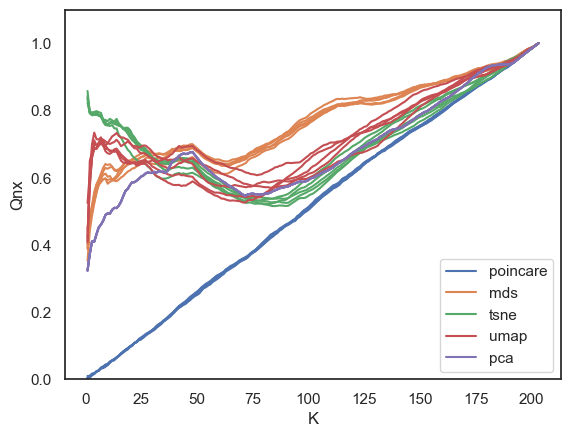

In [22]:
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.savefig("Qnx_global_kinases.pdf")
plt.show()

In [23]:
print("Local")
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare 0.32, 0.02
mds 0.55, 0.02
tsne 0.84, 0.01
umap 0.62, 0.02
pca 0.49, 0.00
Global
poincare 0.82, 0.02
mds 0.78, 0.01
tsne 0.71, 0.00
umap 0.73, 0.01
pca 0.71, 0.00


# 
# 
# 

### Poincaré distances hyperboliques 

In [24]:
for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")

### MDS

In [25]:
X_cosine = pairwise_distances(features,metric='cosine')
X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
df_embedding["x1_mds"] = X_mds[:,0]
df_embedding["x2_mds"] = X_mds[:,1]

In [26]:
D = pairwise_distances(X_mds)
print(D.shape)

for cname in ['agglomerative']:#,'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")

(204, 204)


### t-SNE

In [27]:
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]

In [28]:
D = pairwise_distances(X_tsne)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")

### UMAP

In [29]:
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]

In [30]:
D = pairwise_distances(X_umap)
print(D.shape)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")

(204, 204)


### PCA

In [31]:
X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
df_embedding["x1_pca"] = X_pca[:,0]
df_embedding["x2_pca"] = X_pca[:,1]

In [32]:
D = pairwise_distances(X_pca)
print(D.shape)


for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")

(204, 204)


## Compare scores for clustering

In [35]:
if remove_outliers:
    df_noothers = df_embedding[no_outliers]
if remove_others:
    df_noothers = df_noothers[df_embedding[true_col]!=other]
        
print(df_embedding.shape, df_noothers.shape)

for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

    ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

    if clust_meth == "poincare":
        D = model.distances
        Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
    else:
        D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
        Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)

    corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
    df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
    df_results = df
    print(clust_meth + ": " + f"{ARI:.2f} " + f"{FMS:.2f} " + f"{corr.correlation:.2f} " + f"{Qlocal:.2f} "+f"{Qglobal:.2f} ")
#print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

(204, 18) (202, 18)
Connecting 6
poincare: 0.01 0.22 0.07 0.32 0.82 
Connecting 6
mds: 0.02 0.28 0.88 0.53 0.77 
Connecting 6
tsne: 0.01 0.23 0.45 0.82 0.71 
Connecting 6
umap: 0.03 0.30 0.53 0.64 0.72 
Connecting 6
pca: 0.01 0.24 0.58 0.49 0.71 


In [36]:
print(df_results)

  method  seed    Qlocal   Qglobal true_col       ARI       FMS
0    pca     4  0.486248  0.711172    label  0.008443  0.242526


In [37]:
clust_meth = "tsne"
k_neigh = 5
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]
Qlocalt, Qglobalt, Kmaxt, df_q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5, my_metric = "cosine")
print(Qlocalt, Qglobalt)

Connecting 6
0.8235294117647058 0.7106518366473186


In [38]:
df_q

,Qnx,Bnx
0,0.823529,0.000000
1,0.791667,0.007353
2,0.785948,0.011438
3,0.786765,0.024510
4,0.789216,0.022549
...,...,...
198,0.981082,0.055646
199,0.986152,0.055343
200,0.990050,0.053922
201,0.995050,0.053655


In [39]:
clust_meth = "umap"
k_neigh = 5
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]
Qlocal, Qglobal, Kmax, df_qumap = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)
print(Qlocal, Qglobal)

Connecting 6
0.6420547385620915 0.7236404564034712


In [40]:
df_qumap

,Qnx,Bnx
0,0.524510,0.000000
1,0.610294,0.036765
2,0.699346,0.055556
3,0.734069,0.051471
4,0.714706,0.049020
...,...,...
198,0.979899,0.079269
199,0.985000,0.078873
200,0.990050,0.078480
201,0.995050,0.078092


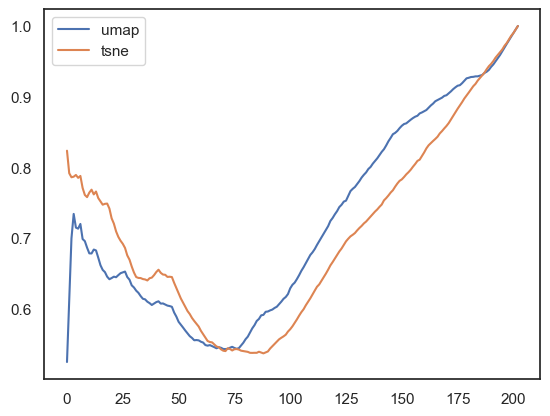

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.legend()
plt.show()

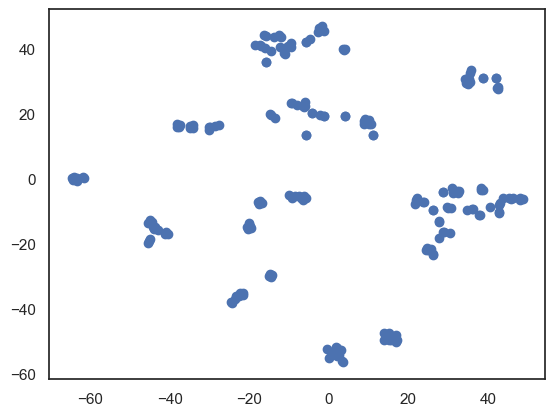

In [42]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

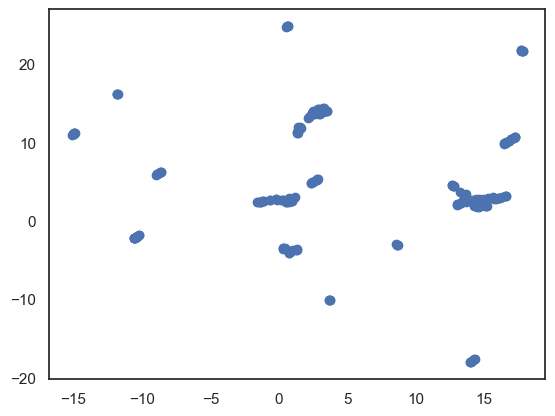

In [43]:
plt.scatter(X_umap[:,0], X_umap[:,1])

In [45]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
poincare_coord = np.array(poincare_coord, dtype = np.float64)

model = PoincareMaps(poincare_coord)
model.get_distances()
clust_meth = "poincare"
k_neigh = 5
Qlocalp, Qglobalp, Kmaxp, df_qumapoin = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
print(Qlocalp, Qglobalp)

Connecting 6
0.3216144123830685 0.8192309187188455


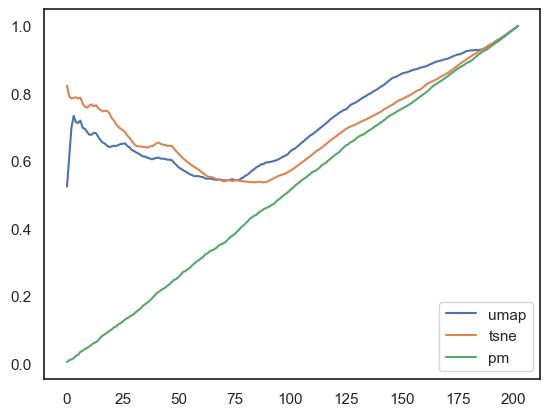

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.plot(df_qumapoin.Qnx, label="pm")
plt.legend()

In [47]:
print(Qlocal, Qglobal)
print(Qlocalt, Qglobalt)

0.6420547385620915 0.7236404564034712
0.8235294117647058 0.7106518366473186


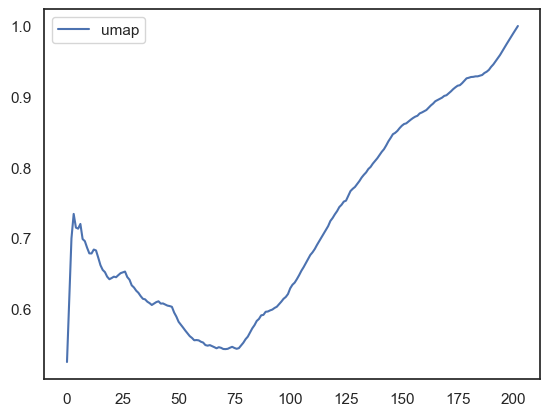

In [48]:

plt.plot(df_qumap.Qnx, label="umap")
plt.legend()

In [49]:
fig = px.strip(df_results, x='method', y='ARI', color = "true_col")
fig.show()

In [50]:
fig = px.strip(df_results, x='method', y='FMS', color = "true_col")
fig.show()

In [51]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['corr'])
fig.show()

In [52]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qglobal'])
fig.show()

In [53]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qlocal'])
fig.show()

# Plots

## PoincaréMSA

In [54]:
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "clust_poincare",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None,
                                 #color_discrete_sequence = px.colors.qualitative.Alphabet,
                                 #color_discrete_map=phosphatase_cols,
                                 #title = title, 
                                 fontsize = 11)
fig.show()


        #        scores.append(s)
#        titles.append(t)

#for cname in ['spectral', 'agglomerative', 'kmedoids']:
 #       s, t = detect_cluster(model.get_distances(), 
  #                            n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        #scores.append(s)
        #titles.append(t)

## MDS

In [55]:
plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                    color = df_embedding["clust_mds"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                    color = df_embedding[true_col],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## tSNE

In [56]:

plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                    color = df_embedding["clust_tsne"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-10 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                    color = df_embedding[true_col],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## UMAP

In [57]:
plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                    color = df_embedding["clust_umap"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-10 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                    color = df_embedding[true_col],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## PCA

In [58]:
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                    color = df_embedding["clust_pca"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )


plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

In [59]:

    
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=phosphatase_cols,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()